# Multi-Seed Late Fusion Analysis

This notebook tests robustness of late fusion results across multiple random seeds.

**Parameterized**: Set `TIMEFRAME` to run PRE or POST analysis.

In [ ]:
# ============================================================================
# CONFIGURATION: Set timeframe for analysis
# ============================================================================
TIMEFRAME = 'POST'  # Change to 'POST' for post-decision analysis
# ============================================================================

import sys
sys.path.append('../..')  # Add project root to path

import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import from src package
from src.utils.io import load_features, save_results
from src.utils.config import get_model_params, load_config
from src.utils.validation import validate_features, validate_modality_features
from src.models.fusion import weighted_late_fusion
from src.visualization.plots import (
    plot_method_comparison,
    plot_modality_weights,
    set_style
)


np.random.seed(42)
sns.set_style('whitegrid')

print(f"\n{'='*70}")
print(f"MULTI-SEED ROBUSTNESS ANALYSIS: {TIMEFRAME}-DECISION PERIOD")
print(f"{'='*70}\n")


MULTI-SEED ROBUSTNESS ANALYSIS: PRE-DECISION PERIOD



## 1. Load Pre-Extracted Features


In [11]:
# Load configuration
config = load_config('model_params')
time_window = config['time_windows'][f'{TIMEFRAME.lower()}_decision']

print(f"Time window: {time_window['start']}s to {time_window['end']}s")
print(f"Description: {time_window['description']}\n")

# Load pre-extracted features
features_path = f'../../data/results/features_{TIMEFRAME}/extracted_features_{TIMEFRAME}.pkl'
feature_data = load_features(features_path, timeframe=TIMEFRAME)

merged_df = feature_data['merged_df']
physio_cols = feature_data['physio_cols']
behavior_cols = feature_data['behavior_cols']
gaze_cols = feature_data['gaze_cols']

# Validate loaded features
validate_features(merged_df, timeframe=TIMEFRAME)

print(f"  Features extracted on: {feature_data['metadata']['extraction_date']}")
if 'baseline_method' in feature_data['metadata']:
    print(f"  Baseline method: {feature_data['metadata']['baseline_method']}")
print(f"\nFeature counts:")
print(f"  Physiology ({TIMEFRAME}): {len(physio_cols)} features")
print(f"  Behavior: {len(behavior_cols)} features")
print(f"  Gaze: {len(gaze_cols)} features")

Time window: -2.0s to 0.0s
Description: Anticipatory period before submit button

✓ Validation passed (PRE): 12511 trials, 97 subjects
  Trials per subject: min=9, max=246, mean=129.0
  Outcome balance: 4273 keep / 8238 invest
  Features extracted on: 2026-01-01 17:53:05
  Baseline method: t3_stable_pre_decision

Feature counts:
  Physiology (PRE): 13 features
  Behavior: 7 features
  Gaze: 20 features


## 2. Prepare Feature Sets


In [12]:
# Prepare feature arrays for model training
X_physio = SimpleImputer(strategy='mean').fit_transform(merged_df[physio_cols])
X_behavior = SimpleImputer(strategy='mean').fit_transform(merged_df[behavior_cols])

# Handle gaze features (may be empty in POST)
if len(gaze_cols) > 0:
    X_gaze = SimpleImputer(strategy='mean').fit_transform(merged_df[gaze_cols])
else:
    # Create placeholder array for POST condition (no gaze data)
    X_gaze = np.zeros((len(merged_df), 1))

y = merged_df['outcome'].values
subjects = merged_df['subject_id'].values

print(f"Shapes: X_physio={X_physio.shape}, X_behavior={X_behavior.shape}, X_gaze={X_gaze.shape}")

Shapes: X_physio=(12511, 13), X_behavior=(12511, 7), X_gaze=(12511, 20)


## 3. Run Multi-Seed Analysis


In [ ]:
# Run multiple seeds
SEEDS = [42, 123, 456, 789, 1024, 2048, 3141, 5678, 8888, 9999]

# Setup modalities based on available data
if len(gaze_cols) > 0:
    X_modalities = [X_physio, X_behavior, X_gaze]
    modality_names = ['Physiology', 'Behavior', 'Gaze']
else:
    # POST condition: no gaze data
    X_modalities = [X_physio, X_behavior]
    modality_names = ['Physiology', 'Behavior']

results = []
for seed in SEEDS:
    print(f"\nRunning seed {seed}...")
    result = weighted_late_fusion(X_modalities, y, subjects, modality_names, seed)
    results.append(result)
    print(f"  Accuracy: {result['accuracy_mean']:.3f} ± {result['accuracy_sem']:.3f} (SEM) / ± {result['accuracy_std']:.3f} (SD)")
    print(f"  F1-Score: {result['f1_mean']:.3f} ± {result['f1_sem']:.3f} (SEM)")
    print(f"  N subjects: {result['n_subjects']}")
    print(f"  Weights: {result['weights']}")


Running seed 42...
  Accuracy: 0.677 ± 0.015 (SEM) / ± 0.143 (SD)
  F1-Score: 0.661 ± 0.017 (SEM)
  N subjects: 97
  Weights: [0.00112893 0.00666249 0.99220859]

Running seed 123...
  Accuracy: 0.678 ± 0.014 (SEM) / ± 0.142 (SD)
  F1-Score: 0.662 ± 0.017 (SEM)
  N subjects: 97
  Weights: [3.93828356e-04 2.11903102e-03 9.97487141e-01]

Running seed 456...
  Accuracy: 0.678 ± 0.014 (SEM) / ± 0.140 (SD)
  F1-Score: 0.663 ± 0.016 (SEM)
  N subjects: 97
  Weights: [3.03751741e-04 1.67173060e-03 9.98024518e-01]

Running seed 789...
  Accuracy: 0.677 ± 0.014 (SEM) / ± 0.141 (SD)
  F1-Score: 0.662 ± 0.016 (SEM)
  N subjects: 97
  Weights: [2.56135303e-04 1.45059226e-03 9.98293272e-01]

Running seed 1024...
  Accuracy: 0.677 ± 0.014 (SEM) / ± 0.140 (SD)
  F1-Score: 0.662 ± 0.016 (SEM)
  N subjects: 97
  Weights: [2.67172119e-04 1.51312726e-03 9.98219701e-01]

Running seed 2048...


## 4. Aggregate Results Across Seeds


In [ ]:
# Create summary DataFrame dynamically based on number of modalities
summary_data = []
for r in results:
    row = {
        'Seed': r['seed'],
        'Accuracy': r['accuracy_mean'],
        'Accuracy_SEM': r['accuracy_sem'],
        'Accuracy_SD': r['accuracy_std'],
        'F1-Score': r['f1_mean'],
        'F1_SEM': r['f1_sem'],
        'F1_SD': r['f1_std'],
    }
    # Add weights dynamically
    for i, mod_name in enumerate(modality_names):
        row[f'{mod_name}_Weight'] = r['weights'][i]
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("MULTI-SEED RESULTS SUMMARY")
print("="*80)
print(summary_df[['Seed', 'Accuracy', 'Accuracy_SEM', 'Accuracy_SD', 'F1-Score', 'F1_SEM']].to_string(index=False))

print("\n" + "="*80)
print("AGGREGATE STATISTICS (using SEM for error bars)")
print("="*80)
print(f"Mean Accuracy: {summary_df['Accuracy'].mean():.3f} ± {summary_df['Accuracy_SEM'].mean():.3f} (avg SEM)")
print(f"Mean F1-Score: {summary_df['F1-Score'].mean():.3f} ± {summary_df['F1_SEM'].mean():.3f} (avg SEM)")
print(f"\nMean Modality Weights:")
for mod_name in modality_names:
    col_name = f'{mod_name}_Weight'
    print(f"  {mod_name:12s}: {summary_df[col_name].mean():.3f} ± {summary_df[col_name].std():.3f}")

print("\n" + "="*80)
print("NOTE: SEM (Standard Error of Mean) is computed from subject-level accuracies")
print("SEM = SD / sqrt(n_subjects), where n_subjects = 10")
print("="*80)


MULTI-SEED RESULTS SUMMARY
 Seed  Accuracy  Accuracy_SEM  Accuracy_SD  F1-Score   F1_SEM
   42  0.681892      0.014482     0.141890  0.667067 0.016554
  123  0.681630      0.014389     0.140986  0.666574 0.016427
  456  0.682334      0.014483     0.141907  0.667221 0.016479
  789  0.683381      0.014422     0.141311  0.668363 0.016558
 1024  0.682034      0.014472     0.141801  0.667102 0.016551
 2048  0.683184      0.014411     0.141194  0.668657 0.016361
 3141  0.682645      0.014580     0.142852  0.667097 0.016686
 5678  0.681937      0.014586     0.142909  0.666506 0.016679
 8888  0.685220      0.014308     0.140186  0.670055 0.016400
 9999  0.681275      0.014417     0.141253  0.665992 0.016500

AGGREGATE STATISTICS (using SEM for error bars)
Mean Accuracy: 0.683 ± 0.014 (avg SEM)
Mean F1-Score: 0.667 ± 0.017 (avg SEM)

Mean Modality Weights:
  Physiology (PRE): 0.008 ± 0.001
  Behavior:          0.082 ± 0.009
  Gaze:              0.910 ± 0.009

NOTE: SEM (Standard Error of Mean)

## 5. Visualizations


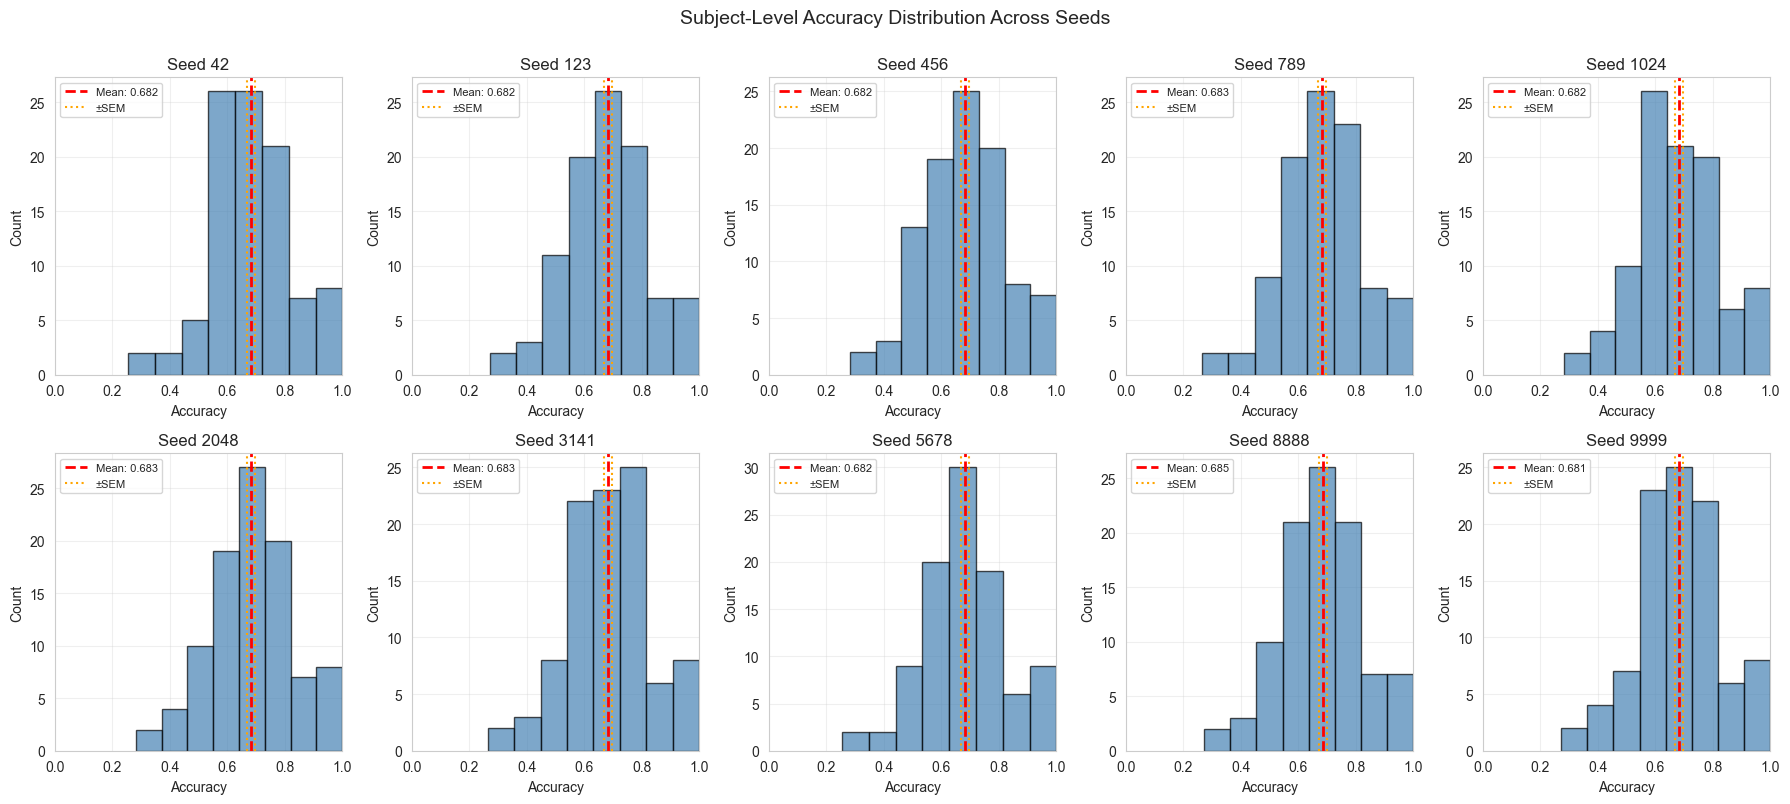

In [ ]:
# Plot distribution of subject-level accuracies
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for idx, result in enumerate(results):
    ax = axes[idx]
    subject_accs = result['accuracy_per_subject']
    
    # Histogram
    ax.hist(subject_accs, bins=8, color='steelblue', alpha=0.7, edgecolor='black')
    ax.axvline(result['accuracy_mean'], color='red', linestyle='--', linewidth=2, 
               label=f"Mean: {result['accuracy_mean']:.3f}")
    ax.axvline(result['accuracy_mean'] - result['accuracy_sem'], color='orange', 
               linestyle=':', linewidth=1.5, label=f"±SEM")
    ax.axvline(result['accuracy_mean'] + result['accuracy_sem'], color='orange', 
               linestyle=':', linewidth=1.5)
    
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Count')
    ax.set_title(f'Seed {result["seed"]}')
    ax.set_xlim([0, 1])
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.suptitle('Subject-Level Accuracy Distribution Across Seeds', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()


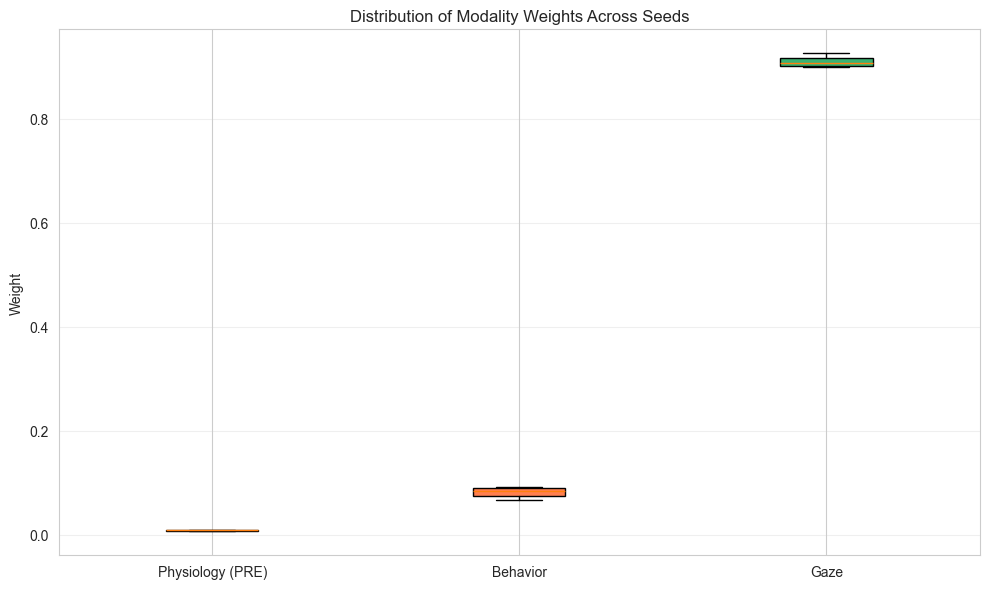

In [ ]:
# Box plots of weights
fig, ax = plt.subplots(figsize=(10, 6))

# Build weight data dynamically based on available modalities
weight_data = []
for mod_name in modality_names:
    col_name = f'{mod_name}_Weight'
    weight_data.append(summary_df[col_name].values)

bp = ax.boxplot(weight_data, labels=modality_names, patch_artist=True)
colors = ['steelblue', 'coral', 'mediumseagreen'][:len(modality_names)]
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Weight')
ax.set_title('Distribution of Modality Weights Across Seeds')
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

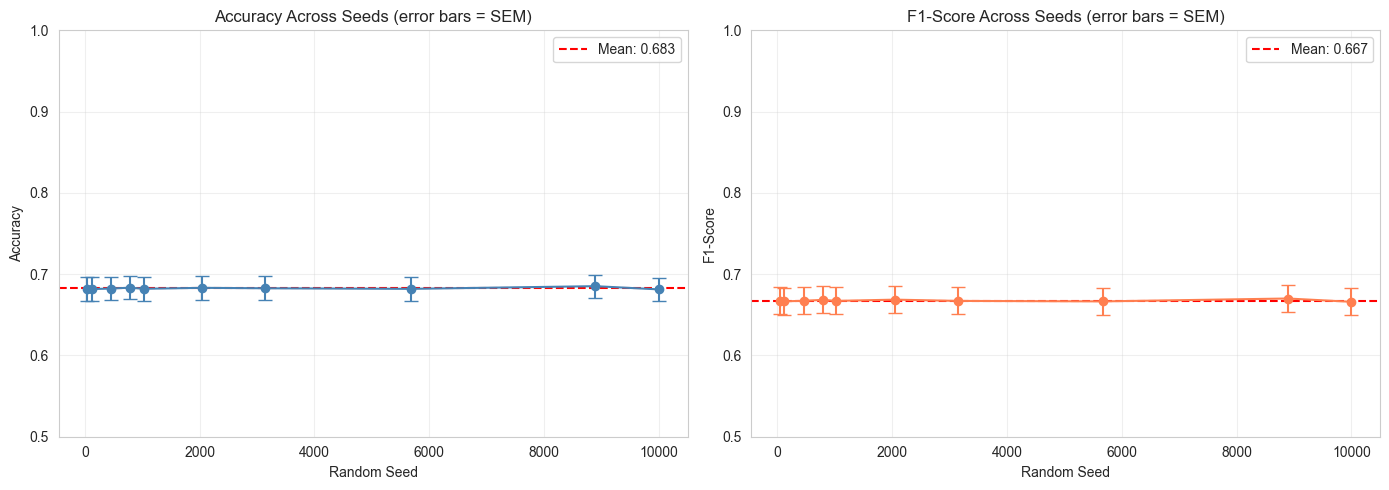

In [ ]:
# Performance across seeds with SEM error bars
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.errorbar(summary_df['Seed'], summary_df['Accuracy'], 
            yerr=summary_df['Accuracy_SEM'], fmt='o-', capsize=5, color='steelblue')
ax.axhline(summary_df['Accuracy'].mean(), color='red', linestyle='--', 
           label=f"Mean: {summary_df['Accuracy'].mean():.3f}")
ax.set_xlabel('Random Seed')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Across Seeds (error bars = SEM)')
ax.set_ylim([0.5, 1.0])
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1]
ax.errorbar(summary_df['Seed'], summary_df['F1-Score'], 
            yerr=summary_df['F1_SEM'], fmt='o-', capsize=5, color='coral')
ax.axhline(summary_df['F1-Score'].mean(), color='red', linestyle='--', 
           label=f"Mean: {summary_df['F1-Score'].mean():.3f}")
ax.set_xlabel('Random Seed')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score Across Seeds (error bars = SEM)')
ax.set_ylim([0.5, 1.0])
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Class Distribution Analysis


In [ ]:
# Analyze class distribution per subject
print("\n" + "="*80)
print("CLASS DISTRIBUTION PER SUBJECT")
print("="*80)

subject_class_dist = merged_df.groupby(['subject_id', 'outcome']).size().unstack(fill_value=0)
subject_class_dist['Total'] = subject_class_dist.sum(axis=1)
subject_class_dist['INVEST_pct'] = (subject_class_dist[1] / subject_class_dist['Total'] * 100).round(1)
subject_class_dist['KEEP_pct'] = (subject_class_dist[0] / subject_class_dist['Total'] * 100).round(1)

print(subject_class_dist.to_string())

print(f"\n{'='*80}")
print("SUMMARY:")
print(f"Mean trials per subject: {subject_class_dist['Total'].mean():.1f}")
print(f"Std trials per subject: {subject_class_dist['Total'].std():.1f}")
print(f"Mean INVEST %: {subject_class_dist['INVEST_pct'].mean():.1f}%")
print(f"Std INVEST %: {subject_class_dist['INVEST_pct'].std():.1f}%")



CLASS DISTRIBUTION PER SUBJECT
outcome              0    1  Total  INVEST_pct  KEEP_pct
subject_id                                              
0806_1000_539136F   38   80    118        67.8      32.2
0806_1000_U9TEJGM   59   72    131        55.0      45.0
0811_1000_4LI8GO7   27   94    121        77.7      22.3
0811_1000_539136F   27  103    130        79.2      20.8
0811_1000_U9TEJGM   38   93    131        71.0      29.0
0813_1000_539136F   77   52    129        40.3      59.7
0813_1000_9M4VCHG   59   64    123        52.0      48.0
0813_1000_U9TEJGM   61   67    128        52.3      47.7
0813_1600_539136F   44   80    124        64.5      35.5
0813_1600_9M4VCHG   52   78    130        60.0      40.0
0813_1600_U9TEJGM   17  106    123        86.2      13.8
0816_1400_539136F   17  112    129        86.8      13.2
0816_1400_9M4VCHG   77   47    124        37.9      62.1
0816_1400_U9TEJGM   38   87    125        69.6      30.4
0817_1000_539136F   57   74    131        56.5      43.5

## Save Results to CSV

Exporting all results for later analysis without re-running.

In [ ]:
# Save results using shared utility
import os
output_dir = f'../../data/results/fusion_model_results_{TIMEFRAME}'
os.makedirs(output_dir, exist_ok=True)

# Save summary DataFrame
save_results(summary_df, 
             f'{output_dir}/multi_seed_late_fusion_{TIMEFRAME}_summary.csv')

print(f"\n✓ All results saved to: {output_dir}/")